In [1]:
from os.path import dirname, join
from pprint import pprint
import os
import pydicom
from PIL import Image
import numpy as np
import ipyplot
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_multiotsu
import pandas as pd
from sklearn.model_selection import KFold
import collections, numpy
import h5py
import seaborn as sns
import SimpleITK as sitk
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm
import pylab as py
from sklearn.preprocessing import minmax_scale
from os.path import join as opj
from collections import Counter
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
import shutil
import io
from PIL import Image

import sys
sys.path.append('/home/ws/oc9627/cerebral_organoid_quant_mri')

from scripts.utils.constants import MRI_ORG_LOC_GT_DIR, MRI_CYST_LOC_GT_DIR, CSV_GLOBAL_CYST_ANNOT, DWMRI_sequences
from scripts.utils.SegmentationPerformanceExtractor import SegmentationPerformanceExtractor
from scripts.utils.SegmentationOverlayVisualizer import SegmentationOverlayVisualizer
from scripts.utils.io_utils import get_orig_imgs, get_organoid_locations
from scripts.utils.global_cyst_classification import get_compactness
from scripts.utils.metrics import calculate_roc_auc

from scripts.utils.visualization import plot_compactness, plot_examples_lq_hq_organoids

wdir = '/home/ws/oc9627/cerebral_organoid_quant_mri'
os.chdir(wdir)

# Organoid segmentation

#### training and testing 3D U-Net (can be skipped: results from previous run are located in results/organoid_segmentation)
- python loocv_'''
- python testing 3D U-Net

#### extract results on test set

In [3]:
pred_dir = 'results/organoid_segmentation/checkpoint_files_3DUNet/all_predictions_on_test_sets'
gt_dir = MRI_ORG_LOC_GT_DIR

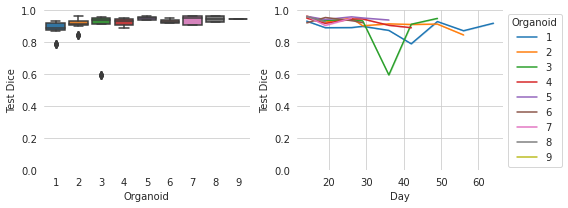

In [4]:
spe = SegmentationPerformanceExtractor(pred_dir = pred_dir,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance(save_to='results/organoid_segmentation/plots/organoid_seg_performance.png')

#### plot weakest, intermediate and best prediction

In [5]:
imgs = get_orig_imgs(kind='mri')

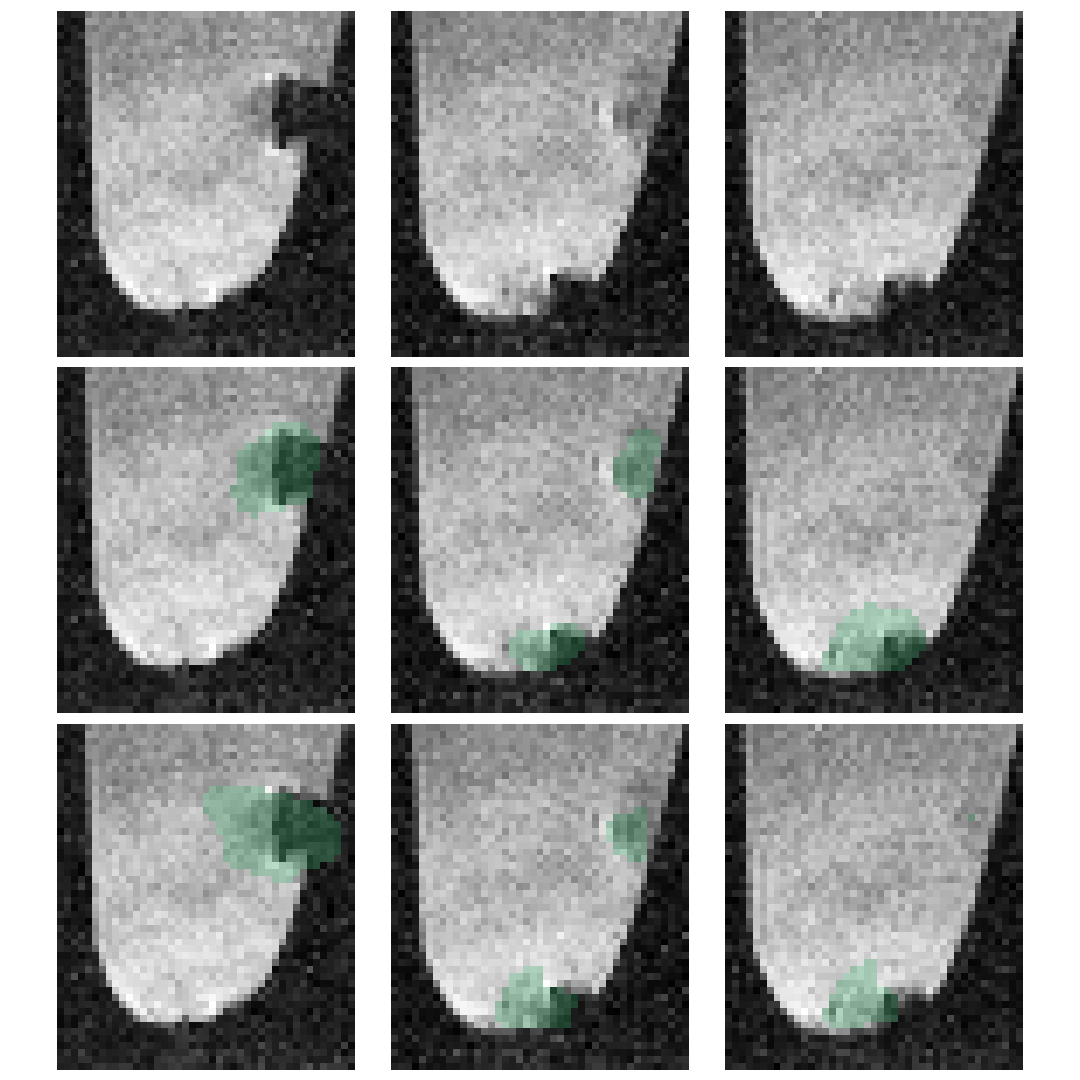

In [8]:
# weakest prediction
sov = SegmentationOverlayVisualizer(imgs,
                                    org_id = 'org3_0609', 
                                    org_loc = [15, 65, 65, 108], 
                                    gt_dir = gt_dir,
                                    pred_dir = pred_dir,
                                    px_threshold=0,
                                    planes='sagittal',
                                    keep_planes=[44, 47, 50],
                                    rot_img=270)
display(sov.plot_segmentation_overlays())


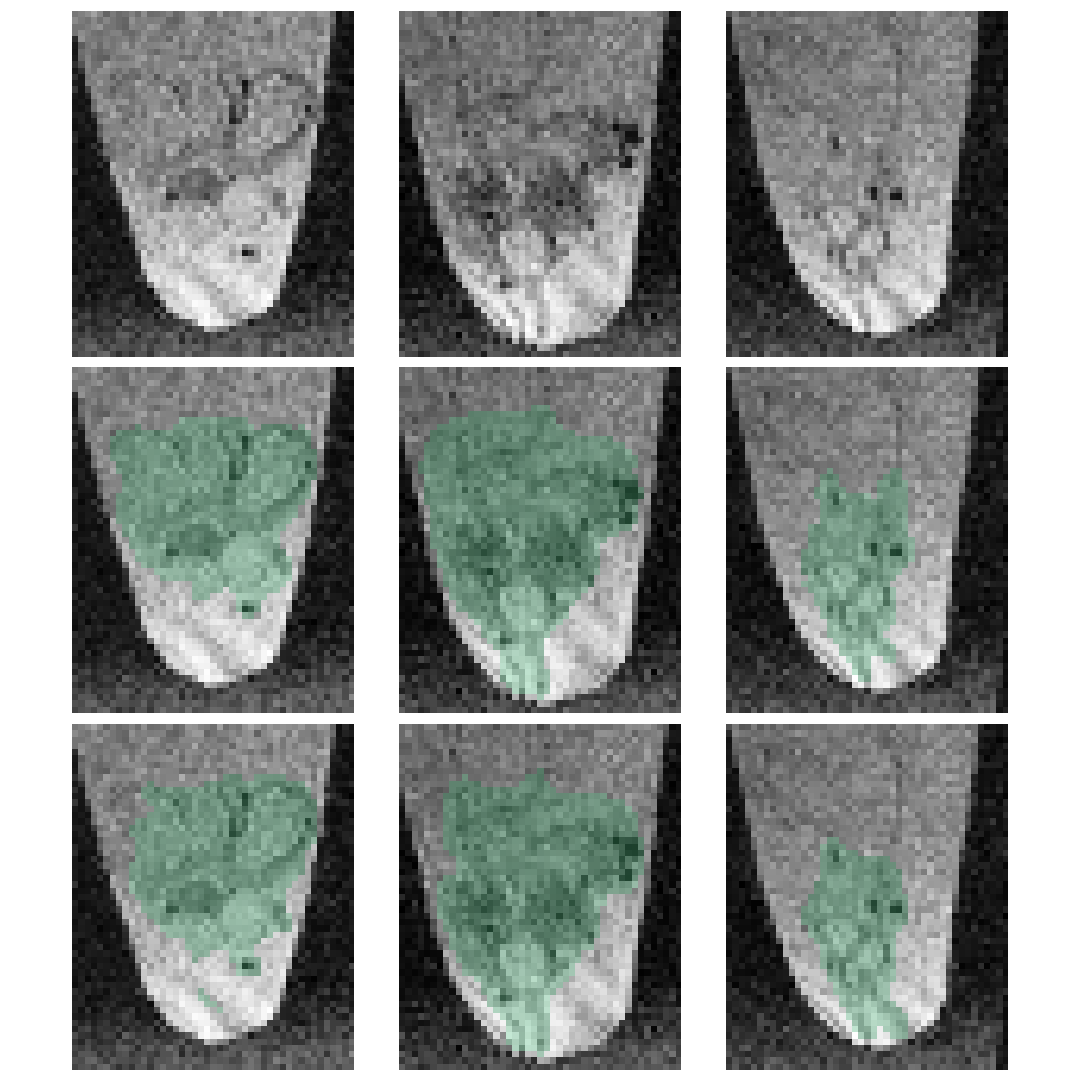

In [6]:
# intermediate prediction
sov = SegmentationOverlayVisualizer(imgs,
                                 org_id = 'org2_0615', 
                                 org_loc = [20, 75, 30, 75], 
                                 gt_dir = gt_dir,
                                 pred_dir = pred_dir,
                                 px_threshold=0,
                                 planes='sagittal',
                                 keep_planes=[40, 50, 58],
                                 rot_img=270)
display(sov.plot_segmentation_overlays())

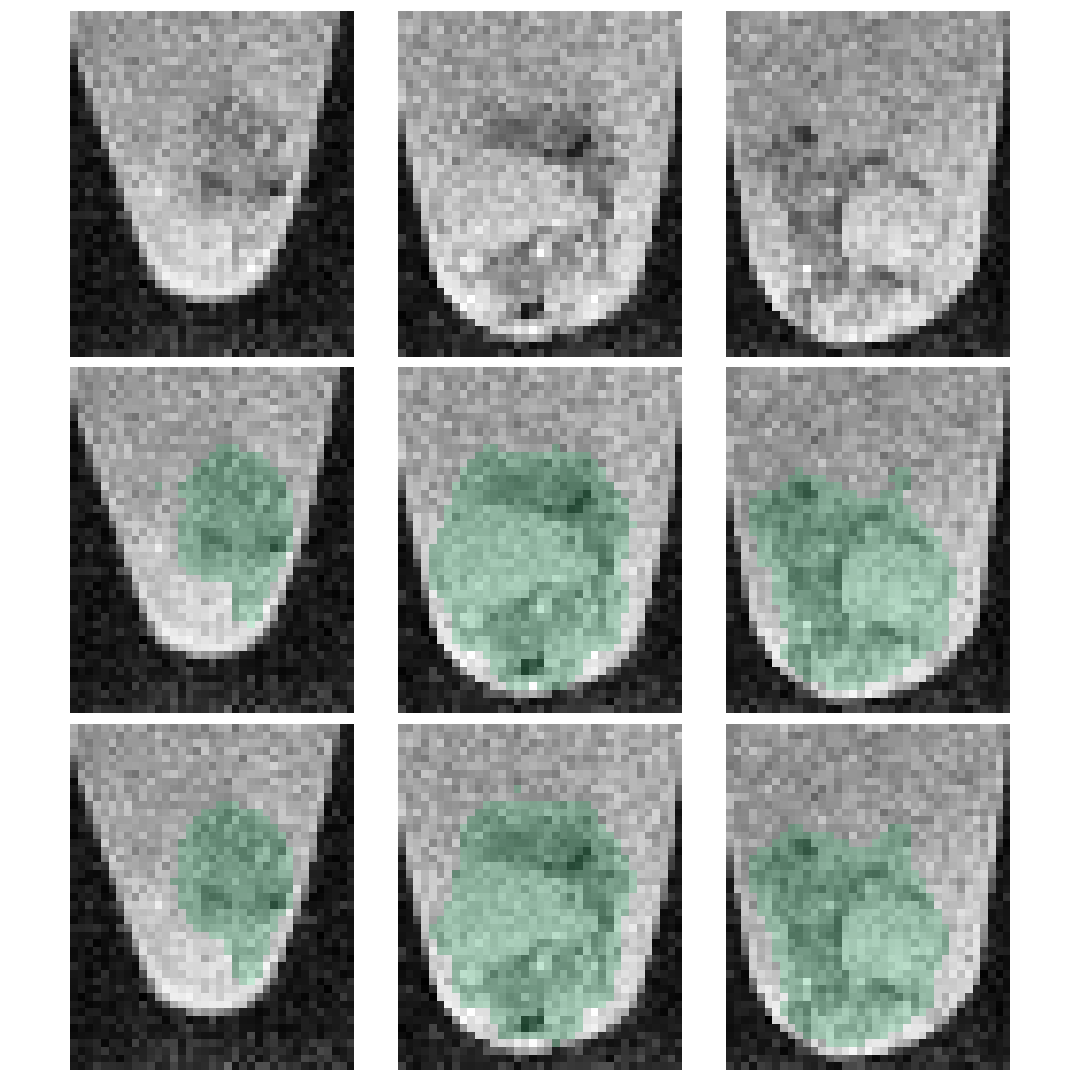

In [6]:
# strongest prediction
sov = SegmentationOverlayVisualizer(imgs,
                                 org_id = 'org5_0530', 
                                 org_loc = [20, 65, 38, 75], 
                                 gt_dir = gt_dir,
                                 pred_dir = pred_dir,
                                 px_threshold=0,
                                 planes='sagittal',
                                 keep_planes=[34, 40, 52],
                                 rot_img=270,
                                 save_to='results/organoid_segmentation/plots/organoid_seg_overlay_org5_0530.png')
display(sov.plot_segmentation_overlays())

# Global cyst classification

#### Calculate mean organoid intensities and compactness

In [2]:
df = get_compactness()

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:41: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  eppendorf_masks_stacked = np.moveaxis(np.stack(np.array(eppendorf_masks)), 0, -1)
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eppendorf_ma

#### Calculate ROC AUC and visualize class separation

ROC AUC for mean organoid intensity:	0.64
ROC AUC for Compactness:		0.98


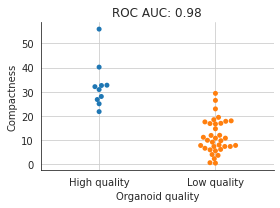

In [3]:
roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
roc_auc_compactness = calculate_roc_auc(df, col='compactness')

print(f'ROC AUC for mean organoid intensity:\t{roc_auc_moi}')
print(f'ROC AUC for Compactness:\t\t{roc_auc_compactness}')

plot_compactness(df, 
                 roc_auc_compactness, 
                 save_to='results/global_cyst_classification/compactness_separates_lq_hq_organoids.png')

#### Visualize examples of LQ and HQ organoids

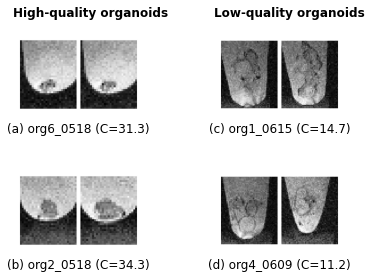

In [2]:
org_ids = ['org6_0518', 'org2_0518', 'org1_0615', 'org4_0609']
compactnesses = [31.3, 34.3, 14.7, 11.2]
# two selected sagittal planes for each organoid
# other ranges to crop images to EV boundaries for better visibility (manually extracted) 
org_locs_planes = [(['88-117', '59', '32-67'], ['88-117', '60', '32-67']),
                   (['40-69', '41', '40-75'], ['40-69', '45', '40-75']),
                   (['5-55', '58', '15-90'], ['5-55', '61', '15-90']),
                   (['17-67', '36', '15-85'], ['17-67', '53', '15-85'])]
plot_examples_lq_hq_organoids(org_ids, 
                              compactnesses,
                              org_locs_planes,
                              save_to='results/global_cyst_classification/examples_lq_hq_organoids.png')

# Local cyst classification

#### extract results

In [4]:
pred_dir = 'results/local_cyst_segmentation/checkpoint_files_3DUNet/all_predictions_on_test_sets'
gt_dir = MRI_CYST_LOC_GT_DIR

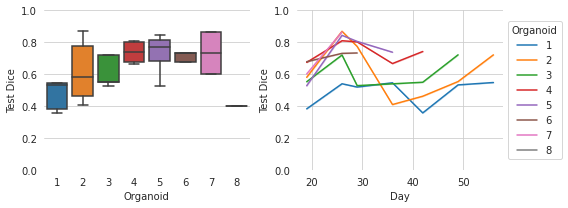

In [6]:
spe = SegmentationPerformanceExtractor(pred_dir = pred_dir,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance(save_to='results/local_cyst_segmentation/plots/local_cyst_seg_performance.png')

#### visualize weakest, intermediate and strongest prediction

In [8]:
imgs = get_orig_imgs(kind='mri')

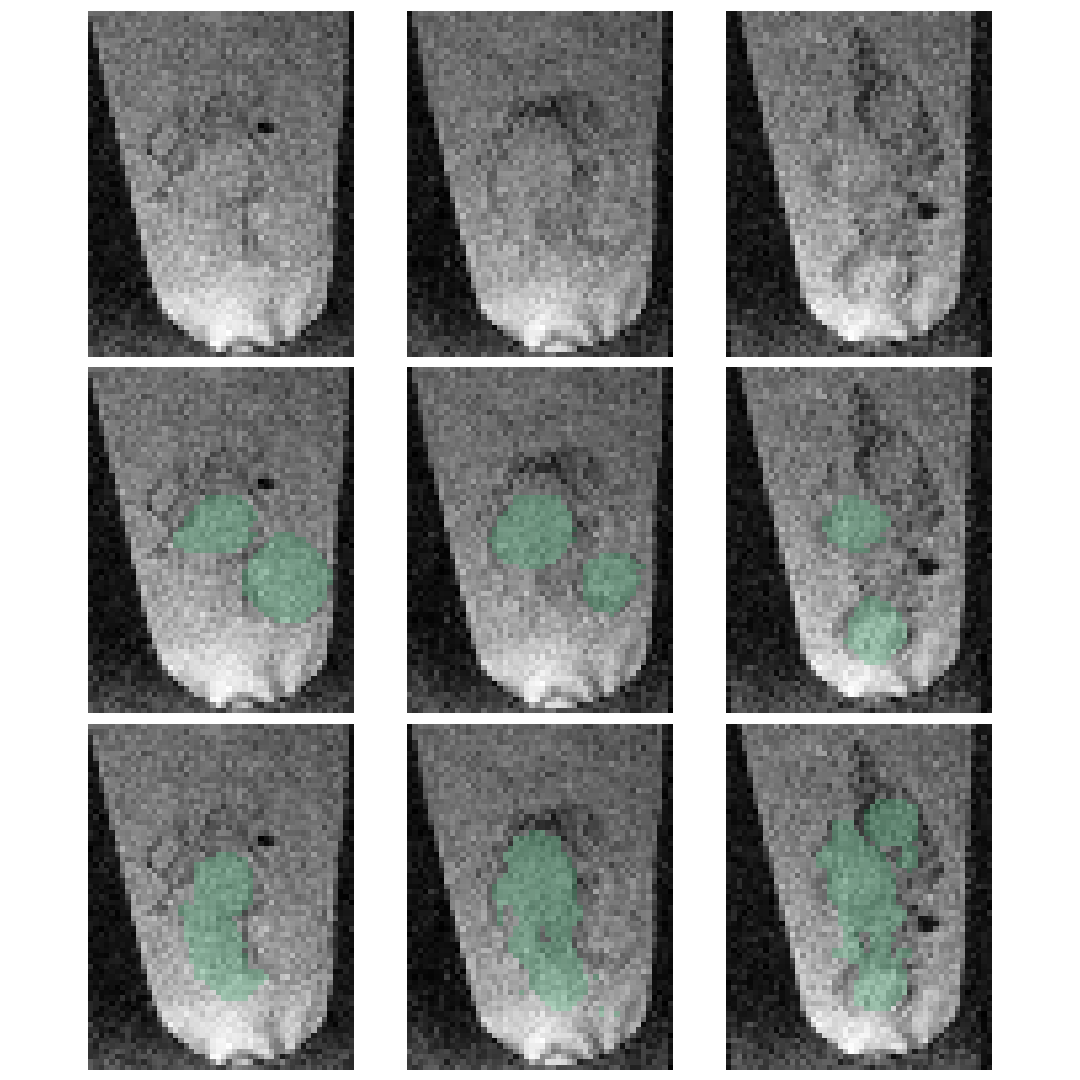

In [333]:
# weakest prediction
plot_gt_pred_org(imgs,
                 org_id = 'org1_0615', 
                 org_loc = [10, 75, 10, 60],
                 gt_dir = gt_dir,
                 pred_dir = pred_dir,
                 planes='sagittal',
                 keep_planes=[60, 55, 51],
                 rot_img=270)

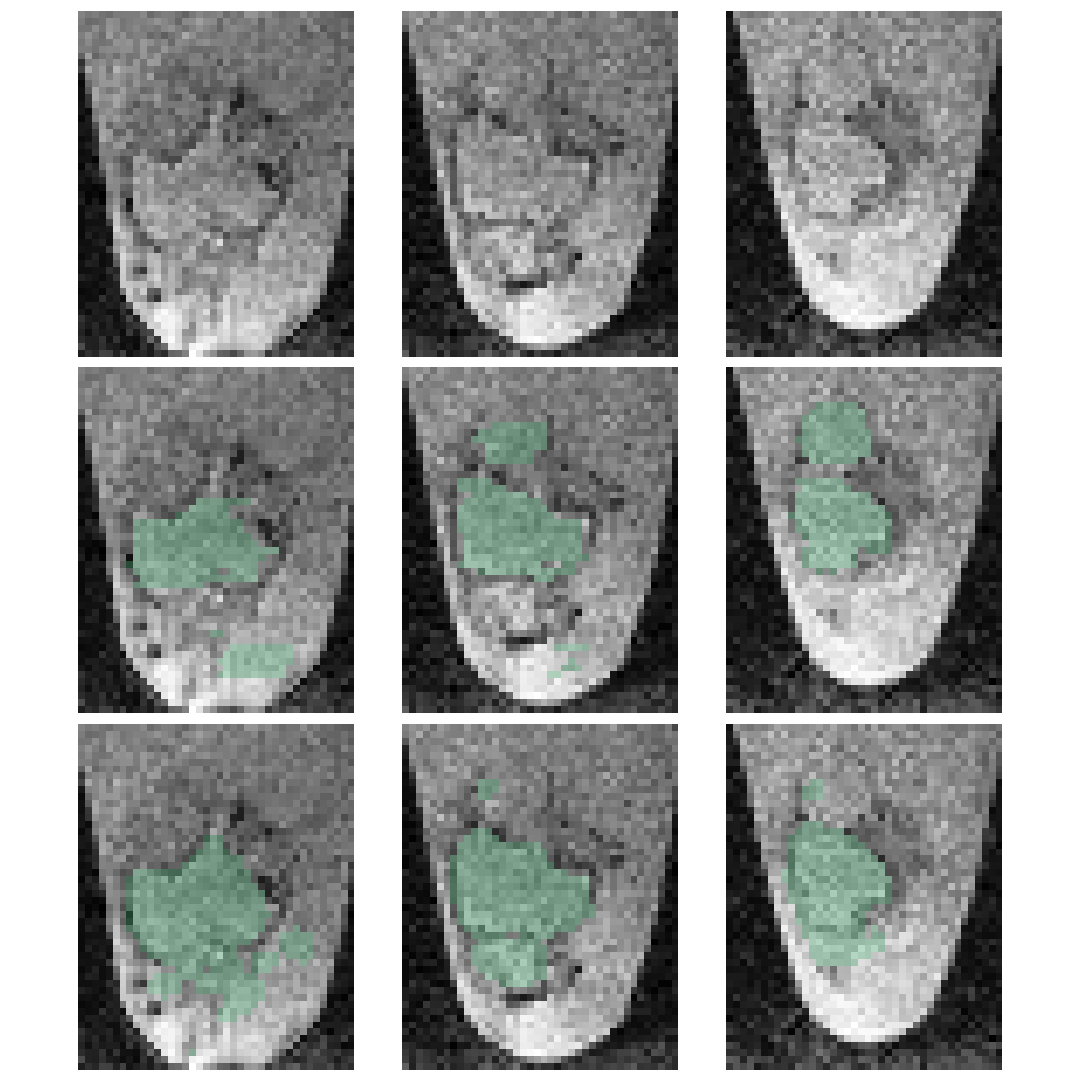

In [334]:
# intermediate prediction
plot_gt_pred_org(imgs,
                 org_id = 'org4_0609', 
                 org_loc=[20, 70, 25, 65], 
                 gt_dir = gt_dir,
                 pred_dir = pred_dir,
                 planes='sagittal',
                 px_threshold=0,
                 keep_planes=[52, 49, 42],
                 rot_img=270)

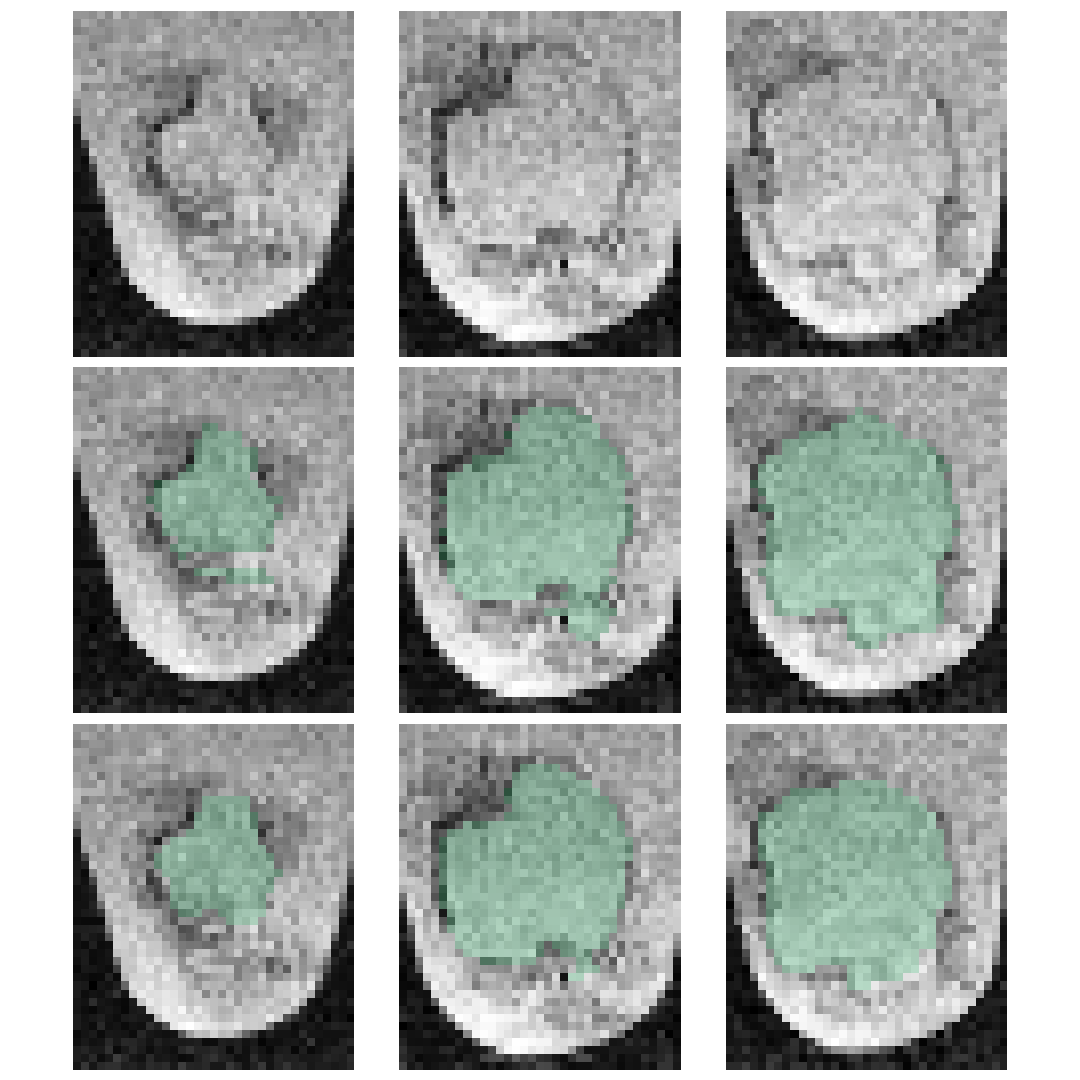

In [9]:
# strongest prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org7_0530', 
                 org_loc=[22, 65, 20, 55], 
                 gt_dir = gt_dir,
                 pred_dir = pred_dir,
                 planes='sagittal',
                 px_threshold=0,
                 keep_planes=[49, 56, 63],
                 rot_img=270,
                 save_to='results/local_cyst_segmentation/plots/cyst_seg_overlay_org7_0530.png')
display(sov.plot_segmentation_overlays())

# DW-MRI to probe tissue characteristics

In [571]:
dw_mri_gt = get_organoid_locations(kind='gt_dwmri')
roc_aucs = []
dfs = {}
for i in range(22):
    imgs_seq = get_orig_imgs(kind='dwmri', seq=i)
    df = get_org_mean_and_compactness(imgs_seq, 
                                      org_loc=dw_mri_gt, 
                                      otsu=None,
                                      only_org_mean=True,
                                      mult_255=False)
    quality_annot = pd.read_csv('mri_paper_data/global_cyst_classification_annotations.csv')
    df = df.merge(quality_annot)
    dfs[i] = df
    roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
    roc_aucs.append(roc_auc_moi)
df_rocaucs = pd.DataFrame.from_dict({'DW-MRI sequence': DWMRI_sequences, 
                             'ROC AUC (LQ/HQ organoids) based on mean organoid intensity': roc_aucs}).sort_values('ROC AUC (LQ/HQ organoids) based on mean organoid intensity', ascending=False)
df_rocaucs

,DW-MRI sequence,ROC AUC (LQ/HQ organoids) based on mean organoid intensity
1,Trace,0.940000
12,3rd Eigenvalue,0.934286
11,2nd Eigenvalue,0.928571
5,Tensor Component Dyy,0.920000
6,Tensor Component Dzz,0.917143
10,1st Eigenvalue,0.911429
4,Tensor Component Dxx,0.888571
18,2nd Eigenvector z,0.740000
21,3rd Eigenvector z,0.682857
3,Trace Weighted Image,0.665714


In [572]:
dfs[1]

,org_id,org_nr,date,mean_organoid_intensity,Organoid quality
0,org3_0622,3,0622,18255.547233,Low quality
1,org5_0518,5,0518,14961.961661,High quality
2,org2_0518,2,0518,14905.021164,High quality
3,org3_0518,3,0518,15505.169065,High quality
4,org4_0609,4,0609,21367.635431,Low quality
5,org6_0523,6,0523,18367.650435,Low quality
6,org2_0609,2,0609,19005.987134,Low quality
7,org5_0609,5,0609,18794.340746,Low quality
8,org5_0530,5,0530,18640.088647,Low quality
9,org2_0630,2,0630,20186.349933,Low quality


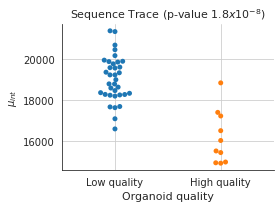

In [574]:
plt.figure(figsize=(4, 3))
sns.swarmplot(data=dfs[1], y='mean_organoid_intensity', x='Organoid quality')
plt.ylabel('$\mu_{int}$')
plt.xlabel('Organoid quality', fontsize=11)
plt.grid()
plt.title(r'Sequence Trace (p-value $1.8x10^{-8}$)', fontsize=11)
sns.despine()
plt.tight_layout()
# plt.savefig('figures/dw-mri_trace_mean_organoid_intensities_org_quality.png', dpi=300)

# TODO
- ~~also create nice readme where I include the images generated here~~
- ~~also create script to show HQ and LQ organoids for global cyst classification~~
- could also include some images showing all sagittal planes from the main text
- ~~put all the code in a folder called data_analysis_utils with scripts like the following
    - ~~data preprocessing~~
    - ~~organoid segmentation~~
    - ~~global cyst classification~~
    - ~~local cyst classification~~
- also include stuff for DW-MRI sequences
    - ~~extraction of single sequences as npy images~~
    - ~~preparation of organoid locations in DW-MRI~~
    - ~~extraction of mean organoid intensities~~
- I think it is overpowered to also have a script to reproduce the exact same figures
- in general, I would put all the data preprocessing and extraction stuff in a separate script, keep the stuff here for data analysis and visualization
- one file with all directories as fixed variables in capital letters

# Supplementary

### organoid segmentation

#### plot organoid growth over time

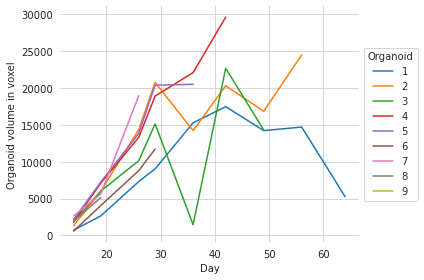

In [536]:
plot_organoid_growth_over_time()
plt.savefig('figures/organoid_growth_over_time.png', dpi=400)

### global cyst classification

#### values for predicted organoid locations (3D U-Net)

/tmp/ipykernel_2668584/206784105.py:65: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  eppendorf_masks_stacked = np.moveaxis(np.stack(np.array(eppendorf_masks)), 0, -1)
/tmp/ipykernel_2668584/206784105.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eppendorf_masks_stacked = np.moveaxis(np.stack(np.array(eppendorf_masks)), 0, -1)


ROC AUC for mean organoid intensity:	0.6485714285714286
ROC AUC for Compactness:		0.9514285714285714


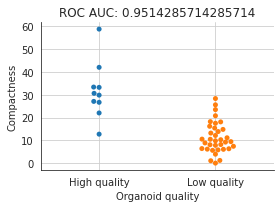

In [432]:
imgs = get_orig_imgs()
gt = get_organoid_locations(kind='predicted')
otsu, _ = get_all_otsu_masks(imgs, gt)

df = get_org_mean_and_compactness(imgs, 
                                  org_loc=gt, 
                                  otsu=otsu)
quality_annot = pd.read_csv('mri_paper_data/global_cyst_classification_annotations.csv')
df = df.merge(quality_annot)

roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
roc_auc_compactness = calculate_roc_auc(df, col='compactness')

print(f'ROC AUC for mean organoid intensity:\t{roc_auc_moi}')
print(f'ROC AUC for Compactness:\t\t{roc_auc_compactness}')

plot_compactness(df, roc_auc_compactness)